In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Data Cleaning

## Reading dataset

__Observation__:
- From looking at the dataset documentation we observe that many of the categorical features contain a value which can be 'NA' or 'None' string. By default `pd.read_csv` would interpret this as a missing values which is not the case.

__Solution__:
- Change the list of strings to be intepreted as missing values

In [3]:
file ='house-prices.csv'
df = pd.read_csv(file, na_values = [''],keep_default_na=False)
df.drop(['Order', 'PID'], axis=1, inplace=True)

In [4]:
df.isna().sum().sum()

np.int64(11670)

In [5]:
df.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,20,RL,75.00,10170,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,160,RM,21.00,2001,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000
3,20,RL,70.00,10552,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,165500
4,190,RM,60.00,10120,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,1,2007,WD,Normal,122000


In [6]:
df.shape

(2430, 80)

__Observation__:
- There are 80 features and 2430 entries
- We observe there's a mix of ordinal and numerical features

Data types of the different columns in the dataset:

In [7]:
print(df.columns)

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Gara

In [8]:
# List of nominal features
nominal_features = [
    "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour",
    "Lot Config", "Neighborhood", "Condition 1", "Condition 2", "Bldg Type",
    "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd",
    "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type",
    "Misc Feature", "Sale Type", "Sale Condition"
]

ordinal_features = [
    "Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond",
    "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure",
    "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", "Electrical", 
    "Kitchen Qual", "Functional", "Fireplace Qu", "Garage Finish", "Garage Qual",
    "Garage Cond", "Paved Drive", "Pool QC", "Fence"
]

discrete_features = [
    "Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath",
    "Bedroom AbvGr", "Kitchen AbvGr", "TotRms AbvGrd", "Fireplaces", "Garage Yr Blt",
    "Garage Cars", "Mo Sold", "Yr Sold", "Year Built", "Year Remod/Add"
]
continuous_features = [
    "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF",
    "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area",
    "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch",
    "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val",
    "Lot Frontage", "Lot Area", "Mas Vnr Area"
]

for col in nominal_features:
        df[col] = df[col].astype('object')

for col in ordinal_features:
        df[col] = df[col].astype('object')

df['Overall Cond'] = df['Overall Cond'].astype('str')
df['Overall Qual'] = df['Overall Qual'].astype('str')

for col in discrete_features:
        df[col] = df[col].astype('Int64')

for col in continuous_features:
        df[col] = df[col].astype('float64')


Next we'll perform the data cleaning operations (Incorrect and missing values, inconsistencies, and outliers) for each datatype separately.

## Target Variable

Text(0, 0.5, 'Counts')

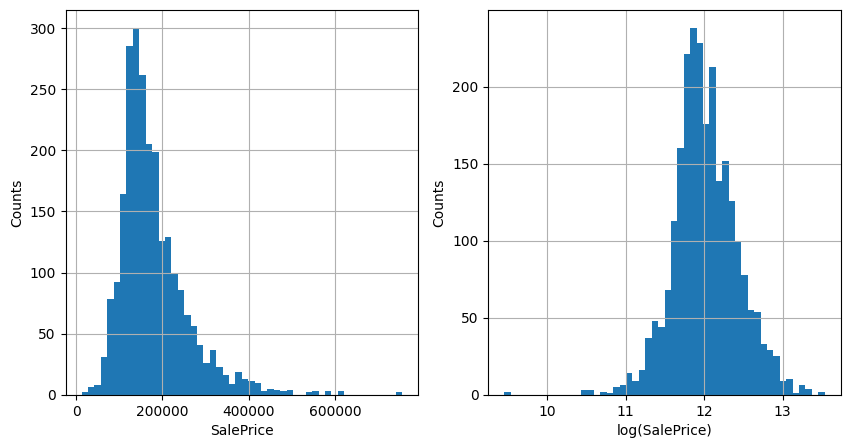

In [9]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

df['SalePrice'].hist(bins=50, ax=axs[0])
axs[0].set_xlabel('SalePrice')
axs[0].set_ylabel('Counts')

saleprice_log = np.log(df['SalePrice'])
saleprice_log.hist(bins=50, ax=axs[1])
axs[1].set_xlabel('log(SalePrice)')
axs[1].set_ylabel('Counts')


__Observation__:
- We observe that the distribution of the target variable resembles a skewed normal distribution
  
__Solution__:
- By applying a log transformation (shown in right-hand side plot), the new distribution more closely resembles a normal distributione
- We'll use the log transformed target variable for our model fitting


In [10]:
df['SalePrice_log'] = saleprice_log

## Nominal Features

In [11]:
print(f'Number of ordinal features: {len(nominal_features)}')

Number of ordinal features: 23


### Missing values:

In [12]:
print(f'Total missing values in ordinal features: {df[nominal_features].isna().sum().sum()}')

Total missing values in ordinal features: 4763


In [13]:
df_ordinal_missing = df[nominal_features].isna().sum().to_frame(name='total')
df_ordinal_missing = df_ordinal_missing[df_ordinal_missing['total']!=0].sort_values('total', ascending=False)
df_ordinal_missing['percentage'] = df_ordinal_missing['total']/len(df)*100
df_ordinal_missing

,total,percentage
Misc Feature,2340,96.30
Alley,2267,93.29
Garage Type,136,5.60
Mas Vnr Type,20,0.82


__Observation__:
- All features with missing values have a category which corresponds to 'None' according to the documentation
- From a quick check of the original CSV file, it is highly probable that these missing values should instead be 'None', corresponding to cases where such a feature is not present

__Solution__:
- Replace the missing values with 'NA'
- Replace all existing values of 'None' with 'NA'

In [14]:
# Replace missing values with 'None'

for feature in ['Misc Feature', 'Alley', 'Garage Type', 'Mas Vnr Type']:
    df[feature] = df[feature].fillna('NA')
    
for feature in nominal_features:
    df[feature].replace('None','NA', inplace=True)

In [15]:
print("Missing values in Nominal columns after cleaning: ", df[nominal_features].isna().sum().sum())

Missing values in Nominal columns after cleaning:  0


### Feature distribution:

We next observe the distribution of all the features

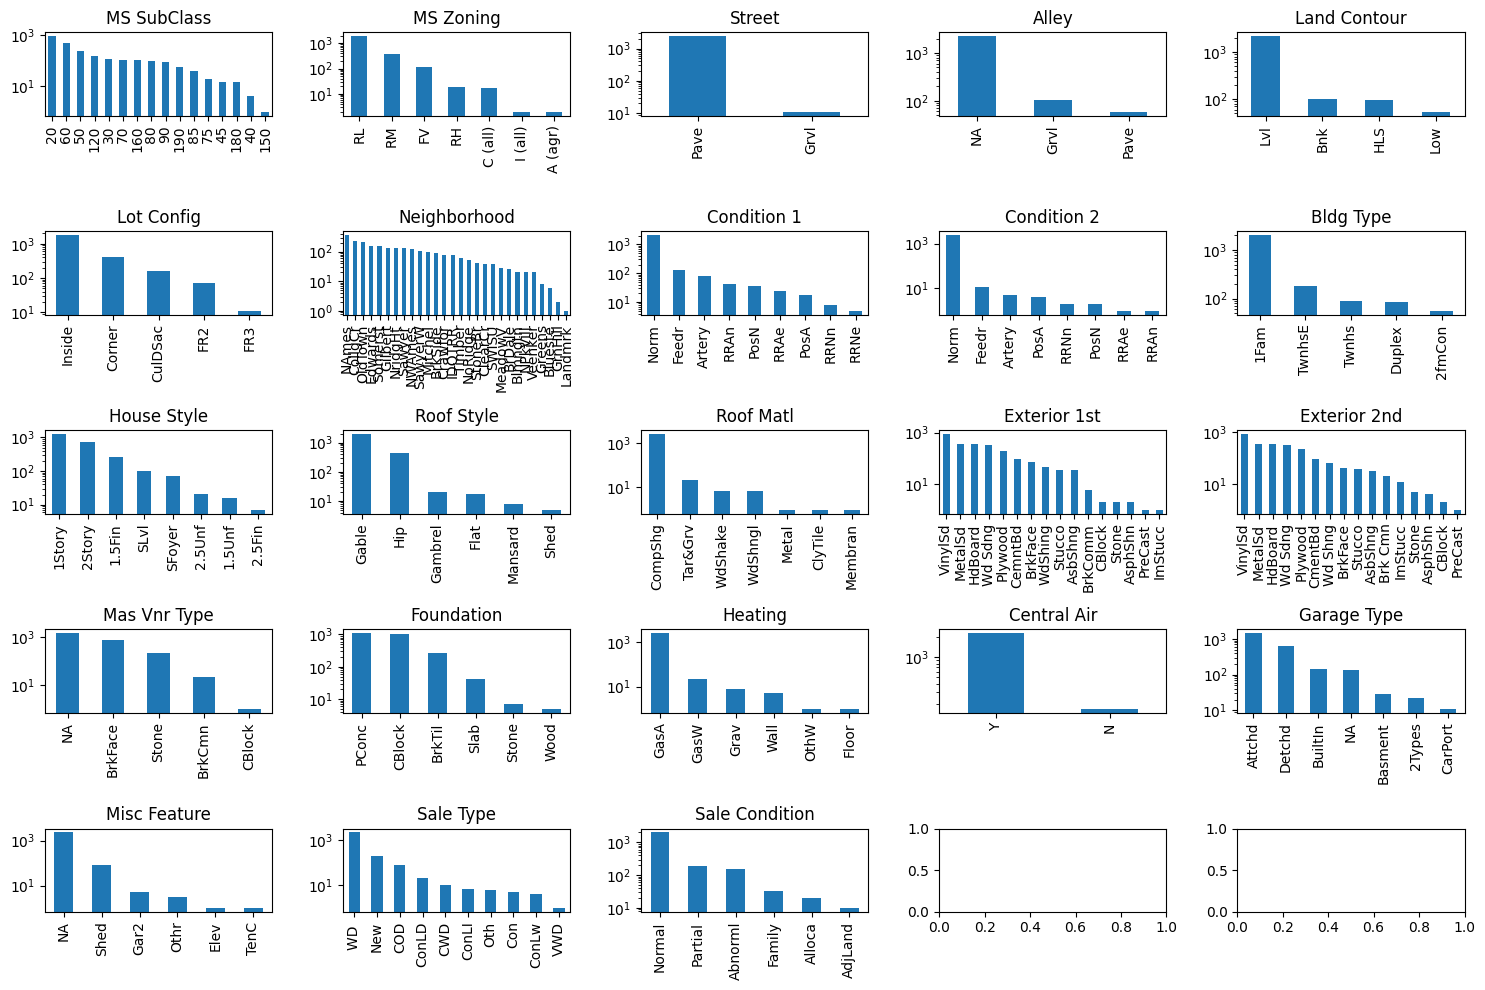

In [16]:
n_cols = 5
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, col in enumerate(nominal_features):
    r, c = np.divmod(i, n_cols)
    df[col].value_counts().plot(kind='bar', ax=axs[r, c], logy=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

__Observation__
- For most features there's a a difference in 1 or more orders of magnitude between most and least frequent values

__Solution__
- As part of Outlier removal, we may decide to remove the entries whose feature values correpond to the correponding to least  represented categories

### Outlier removal

Our objective for this model is to predict the Sale Price of "normal" residential homes, without considering very rare or specific types of propetries that are represented by very few entries in the dataset.
Hence, our strategy for outlier removal will be to remove entries which have categories or range of values that fall outside of the more populated categories or range of values.
As said, these may represent real property purchases, but they like are properties other than "normal" residential homes. For example, there's a single entry for which the zoning classification "MS Zoning" is Industrial "I". It makes sense to remove since we aim at modeling only residential properties and not industrial properties.

We also stipulated that we can affort to drop a maximum of 5% of the total dataset entries (initially there are 2430), in order to assure we still have a statistically representative dataset for training.


__Nominal Features: Categories which populated with minimum of entries__

In [17]:
print(f'{"Feature":<20}|{"Category_MinCount":<20}|{"MinCount":<20}')
print("-"*50)
for feature in nominal_features:
    
    # Get the number of entries per category
    category_counts = df[feature].value_counts()
    min_count_category = category_counts.idxmin()

    # Display the counts
    print(f'{feature:<20}|{min_count_category:<20}|{min(category_counts):<20}')

Feature             |Category_MinCount   |MinCount            
--------------------------------------------------
MS SubClass         |150                 |1                   
MS Zoning           |I (all)             |2                   
Street              |Grvl                |11                  
Alley               |Pave                |59                  
Land Contour        |Low                 |54                  
Lot Config          |FR3                 |11                  
Neighborhood        |Landmrk             |1                   
Condition 1         |RRNe                |5                   
Condition 2         |RRAe                |1                   
Bldg Type           |2fmCon              |56                  
House Style         |2.5Fin              |7                   
Roof Style          |Shed                |5                   
Roof Matl           |Metal               |1                   
Exterior 1st        |PreCast             |1                   
Exte

__Observation__:
- For about half of the features there's at least one category populated with just 1 or 2 entries

__Solution__:
- We decide to remove the entries for which there's <=2 counts of a given category;
- We check how many entries we dropped

In [18]:
threshold = 2

for feature in nominal_features:

    category_counts = df[feature].value_counts()
    # Identify categories with counts <= threshold
    low_count_categories = category_counts[category_counts <= threshold].index
    # Filter out entries with low count categories
    df = df[~df[feature].isin(low_count_categories)]


In [19]:
print(f'Percentage of dropped entries: {(2430-df.shape[0])/2430*100:.2f}%')

Percentage of dropped entries: 1.36%


### Relationship with target variable

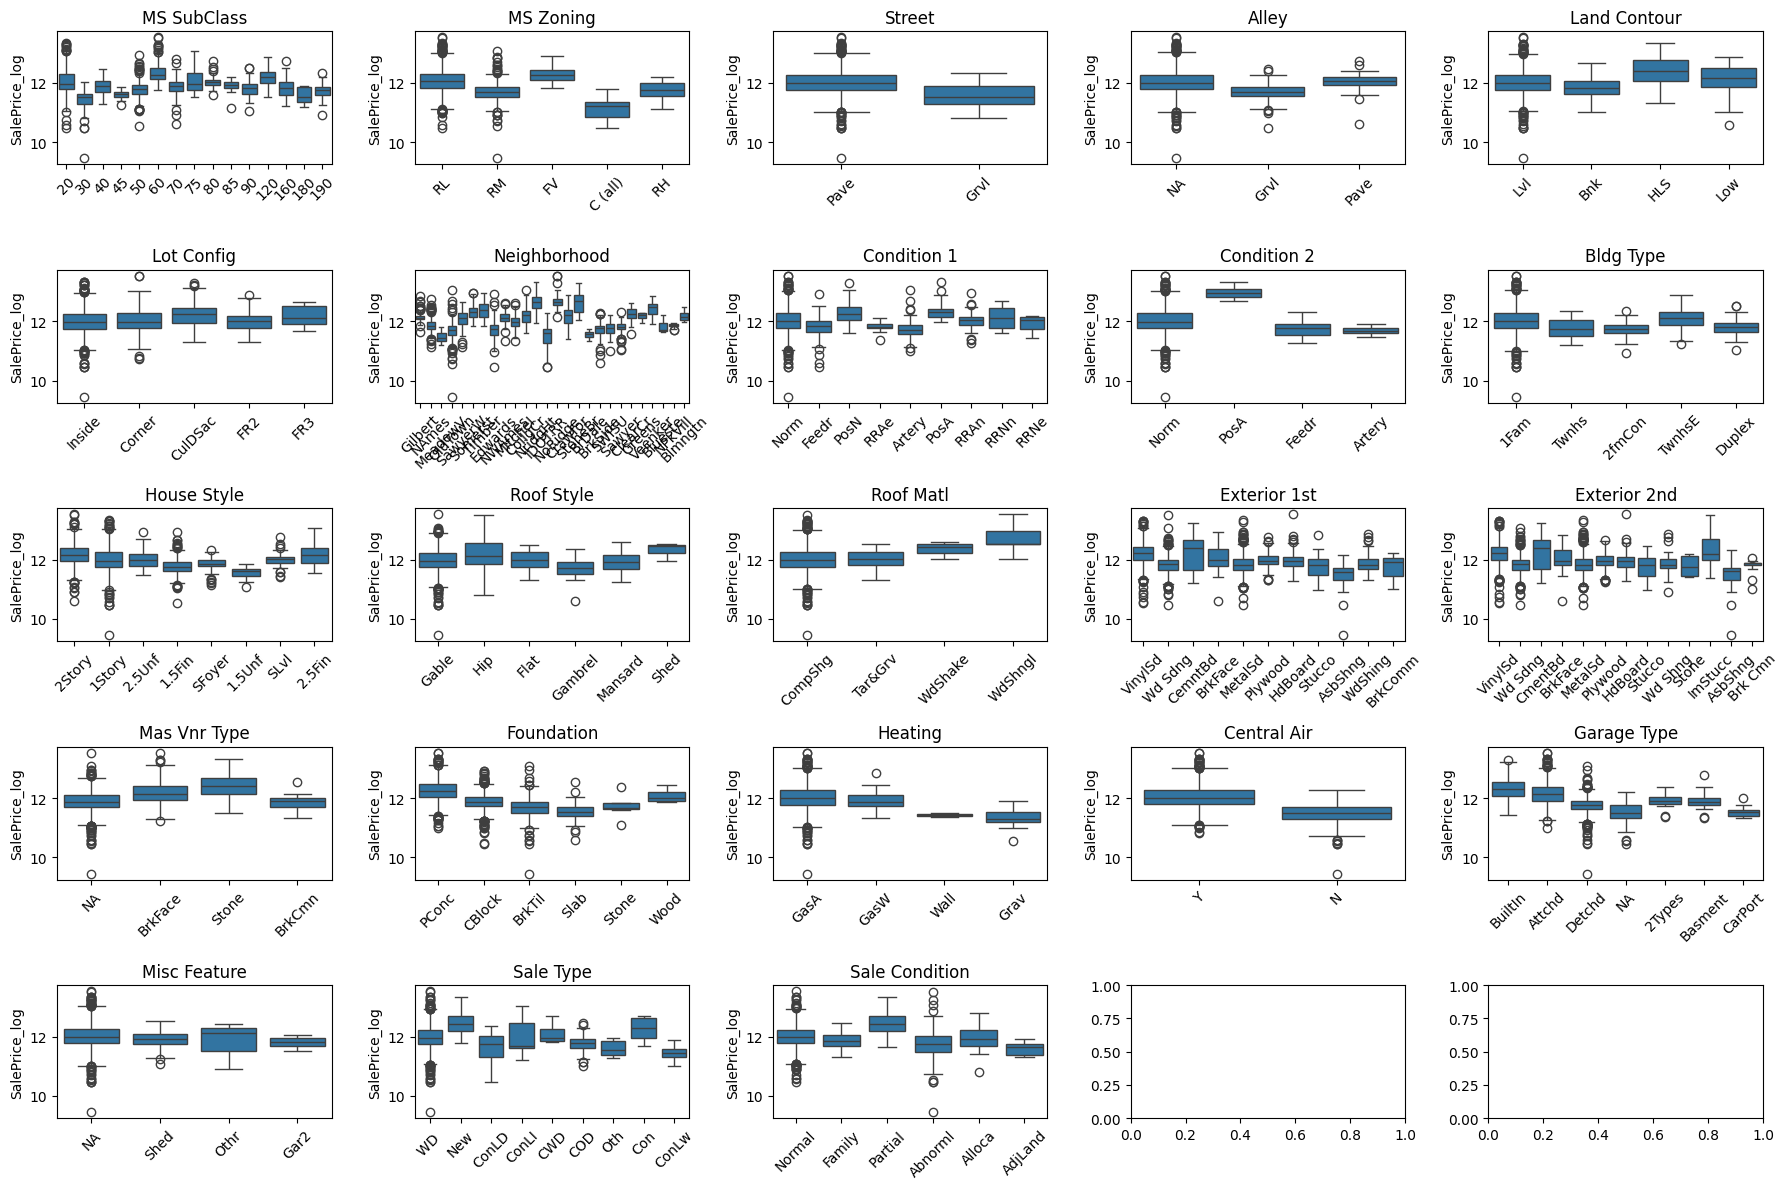

In [20]:
n_cols = 5
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 12))

for i, col in enumerate(nominal_features):
    r, c = np.divmod(i, n_cols)
    sns.boxplot(x=col, y='SalePrice_log', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    for label in axs[r, c].get_xticklabels():
        label.set_rotation(45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

__Observations__:
- The following features present a high number of categories: 'MS Subclass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd'. It could be interesting to group these in fewer categories as a function of 'Sale Price'
- Features such as 'MS Zoning', 'Condition 1', 'Condition 2', 'Roof Mtl',  seem to present an order relation wrt to 'Sale Price'. It could make sense to convert these into ordinal features.
- Some features present little relationship with target variable: 'Lot Config', 'Misc Feature'. Maybe these could be dropped

## Feature Engineering

We apply the grouping strategy to 'MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd'

In [21]:
# df_feature = pd.DataFrame()
# df_feature['SalePrice'] = df['SalePrice']   

In [22]:
# # Apply the function to each high-cardinality feature
# for feature in ['MS SubClass', 'Neighborhood', 'Exterior 1st', 'Exterior 2nd']:

#     # Calculate mean SalePrice for each category    
#     mean_sale_price = df.groupby(feature)['SalePrice'].mean()
    
#     # Bin the mean SalePrice into 4 groups
#     bins = 5
#     sale_price_bins = pd.qcut(mean_sale_price, q=bins, labels=[f"bin_{i+1}" for i in range(bins)])
 
#     # add feature to dataframe of features engineering   
#     df_feature[f"{feature}_grouped"] = df[feature].map(sale_price_bins)
    
    
# n_cols = 2
# n_rows = 2

# fig, axs = plt.subplots(n_rows, n_cols, figsize=(13, 7))

# for i, col in enumerate(['MS SubClass_grouped', 'Neighborhood_grouped', 'Exterior 1st_grouped', 'Exterior 2nd_grouped']):
#     r, c = np.divmod(i, n_cols)
#     sns.boxplot(x=col, y='SalePrice_log', data=df_feature, ax=axs[r, c])
#     #axs[r, c].set_yscale('log')
#     axs[r, c].set_title(col, y=1.0)
#     axs[r, c].set_xlabel('')

    

We apply the order encoding to 'MS Zoning', 'Condition 1', 'Condition 2', 'Roof Mtl' as well as to the new features 'MS SubClass_grouped', 'Neighborhood_grouped', 'Exterior 1st_grouped'

## Ordinal Features

In [23]:
print(f'Number of ordinal features: {len(ordinal_features)}')

Number of ordinal features: 23


### Missing values:

In [24]:
print(f'Total missing values: {df[ordinal_features].isna().sum().sum()}')

Total missing values: 6201


In [25]:
df_ordinal_missing = df[ordinal_features].isna().sum().to_frame(name='total')
df_ordinal_missing = df_ordinal_missing[df_ordinal_missing['total']!=0].sort_values('total', ascending=False)
df_ordinal_missing['percentage'] = df_ordinal_missing['total']/len(df)*100
df_ordinal_missing

,total,percentage
Pool QC,2387,99.58
Fence,1915,79.89
Fireplace Qu,1169,48.77
Garage Finish,135,5.63
Garage Cond,135,5.63
Garage Qual,135,5.63
Bsmt Exposure,67,2.80
BsmtFin Type 2,65,2.71
BsmtFin Type 1,64,2.67
Bsmt Cond,64,2.67


__Observation__:
- Except for 'Electrical' all other features have a value which corresponds to 'None' according to the dataset doc 
- From a quick check of the original CSV file, it is highly probable that these missing values should instead be 'None', corresponding to cases where such a feature is not present

__Solution__:
- Replace the missing value for 'Electrical' with the mode
- Replace the missing values of remaining features with 'NA'
- Replace all existing values of 'None' with 'NA'

In [26]:
# Replace missing values with the mode
mode_value = df['Electrical'].mode()[0]
df['Electrical'].fillna(mode_value, inplace=True)

In [27]:
# Replace missing values with 'None'
df[ordinal_features] = df[ordinal_features].fillna('NA')
df[ordinal_features].replace('None','NA', inplace=True)

In [28]:
print("Missing values in Ordinal columns after cleaning: ", df[ordinal_features].isna().sum().sum())

Missing values in Ordinal columns after cleaning:  0


### Feature distribution:

We next observe the distribution of all the features

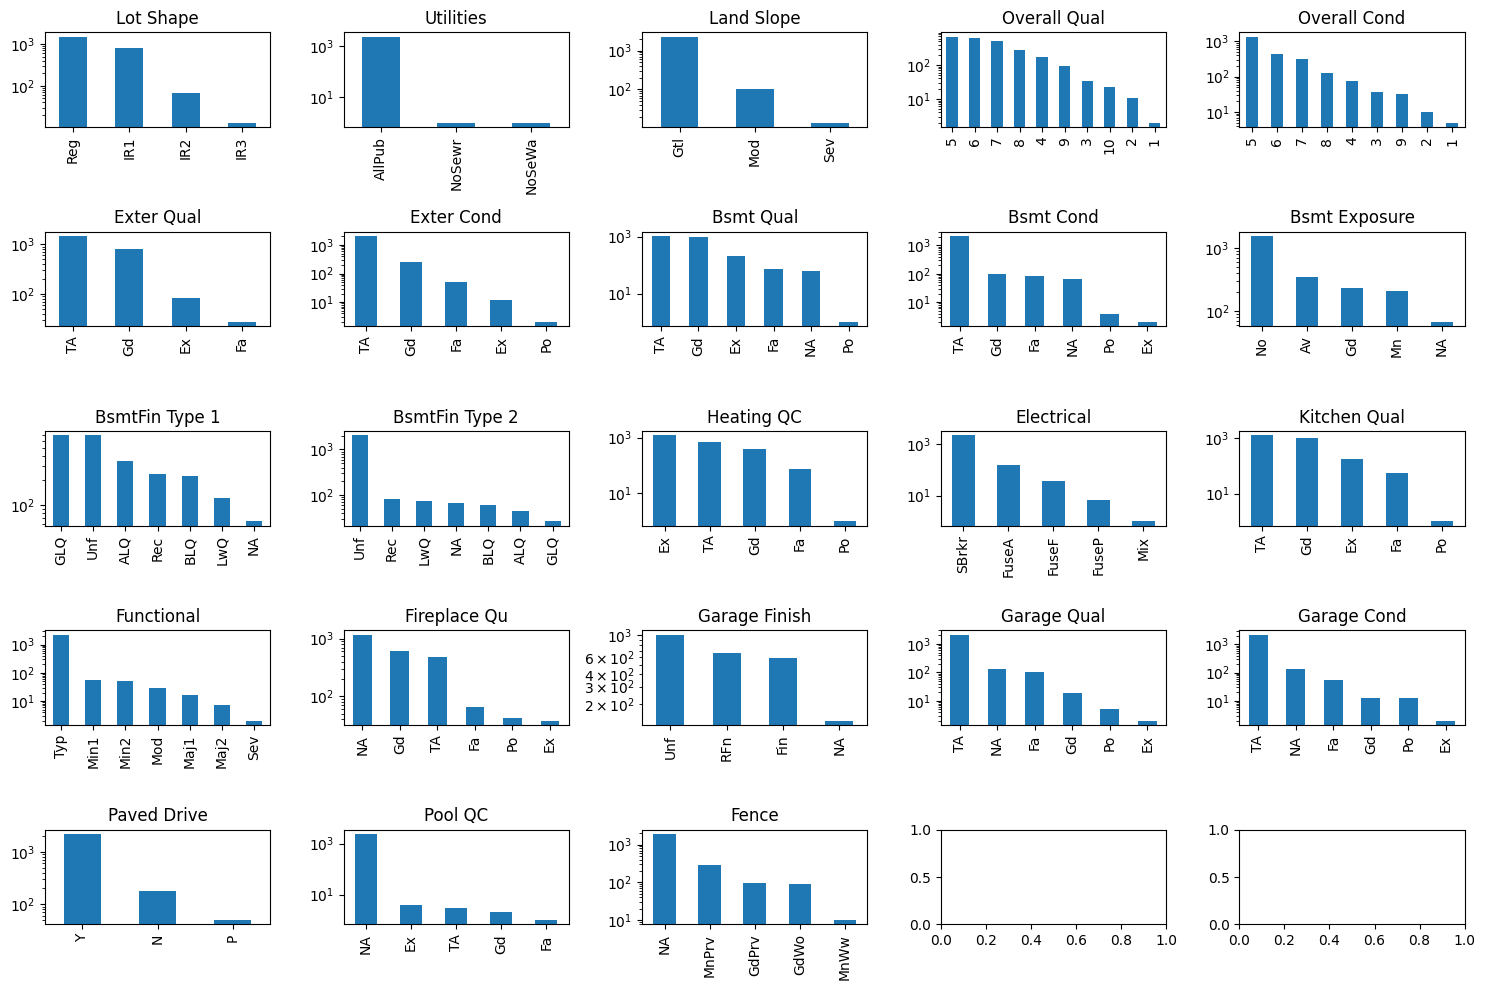

In [29]:
n_cols = 5
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, col in enumerate(ordinal_features):
    r, c = np.divmod(i, n_cols)
    df[col].value_counts().plot(kind='bar', ax=axs[r, c], logy=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

__Observation__
- For most features there's a a difference in 1 or more orders of magnitude between most and least frequent values
- For the case of categorical variables it doesn't make sense to talk about outlier points, since all values are in principle accepted as valid

### Outlier removal

__Ordinal Features: Categories populated with minimum of entries__

In [30]:
print(f'{"Feature":<20}|{"MinCountCategory":<20}|{"MinCount":<20}')
print("-"*50)
for feature in ordinal_features:
    
    # Get the number of entries per category
    category_counts = df[feature].value_counts()
    min_count_category = category_counts.idxmin()

    # Display the counts
    print(f'{feature:<20}|{min_count_category:<20}|{min(category_counts):<20}')

Feature             |MinCountCategory    |MinCount            
--------------------------------------------------
Lot Shape           |IR3                 |13                  
Utilities           |NoSewr              |1                   
Land Slope          |Sev                 |14                  
Overall Qual        |1                   |2                   
Overall Cond        |1                   |5                   
Exter Qual          |Fa                  |27                  
Exter Cond          |Po                  |2                   
Bsmt Qual           |Po                  |1                   
Bsmt Cond           |Ex                  |2                   
Bsmt Exposure       |NA                  |67                  
BsmtFin Type 1      |NA                  |64                  
BsmtFin Type 2      |GLQ                 |26                  
Heating QC          |Po                  |1                   
Electrical          |Mix                 |1                   
Kitc

__Observation__:
- Again, for about half of the features there's at least one category populated with just 1 or 2 entries

__Solution__:
- We decide to remove the entries for which there's <=2 counts of a given category;
- We check how many entries we dropped

In [31]:
threshold = 2

for feature in ordinal_features:

    category_counts = df[feature].value_counts()
    # Identify categories with counts <= threshold
    low_count_categories = category_counts[category_counts <= threshold].index
    # Filter out entries with low count categories
    df = df[~df[feature].isin(low_count_categories)]


In [32]:
print(f'Percentage of dropped entries: {(2430-df.shape[0])/2430*100:.2f}%')

Percentage of dropped entries: 2.18%


## Encoding with numerical scale

__Observation__:
- These features having an ordinal nature we can  directly encode them into a single numerical discrete variables, instead of using on-hot encoding

  
__Solution__:
- Assume a linear relationship between 'SalePrice' and all the categorical ordinal features (following observation of previous plots and information in documentation)
- Encode the remaining nominal features using "one-hot encoding"

In [33]:
encoding_order = {
    'Lot Shape': ['IR3', 'IR2', 'IR1', 'Reg'], 
    'Utilities': ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    'Land Slope': ['Sev', 'Mod', 'Gtl'],
    'Overall Qual': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    'Overall Cond': ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    'Exter Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Exter Cond': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Bsmt Qual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Bsmt Cond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Bsmt Exposure': ['NA', 'No', 'Mn', 'Av', 'Gd'], 
    'BsmtFin Type 1': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'BsmtFin Type 2': ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    'Heating QC': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Electrical': ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'],
    'Kitchen Qual': ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Functional': ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    'Fireplace Qu': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Garage Finish': ['NA', 'Unf', 'RFn', 'Fin'],
    'Garage Qual': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Garage Cond': ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    'Paved Drive': ['N', 'P', 'Y'],
    'Pool QC': ['NA', 'Fa', 'TA', 'Gd', 'Ex'],
    'Fence': ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'],
}


In [35]:
df.columns

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Gara

In [44]:
# Create an empty DataFrame to store the encoded columns
for feature, order in encoding_order.items():
    # convert feature to category with specified order
    df[feature] = pd.Categorical(df[feature], categories=order, ordered=True)

    # replace categories with numerical encoded ones, and drop orginal
    df[feature+'_enc'] = df[feature].cat.codes
    df.drop(feature, axis=1)

ordinal_features = [feature+'_enc' for feature in ordinal_features]

In [46]:
# check if the features have been encoded correctly for all existing categories
for feature in ordinal_features:
    print(f'{feature}: {np.sort(df[feature].unique())}')

Lot Shape_enc: [0 1 2 3]
Utilities_enc: [3]
Land Slope_enc: [0 1 2]
Overall Qual_enc: [1 2 3 4 5 6 7 8 9]
Overall Cond_enc: [0 1 2 3 4 5 6 7 8]
Exter Qual_enc: [1 2 3 4]
Exter Cond_enc: [1 2 3 4]
Bsmt Qual_enc: [0 2 3 4 5]
Bsmt Cond_enc: [0 1 2 3 4]
Bsmt Exposure_enc: [0 1 2 3 4]
BsmtFin Type 1_enc: [0 1 2 3 4 5 6]
BsmtFin Type 2_enc: [0 1 2 3 4 5 6]
Heating QC_enc: [1 2 3 4]
Electrical_enc: [1 2 3 4]
Kitchen Qual_enc: [1 2 3 4]
Functional_enc: [2 3 4 5 6 7]
Fireplace Qu_enc: [0 1 2 3 4 5]
Garage Finish_enc: [0 1 2 3]
Garage Qual_enc: [0 1 2 3 4]
Garage Cond_enc: [0 1 2 3 4]
Paved Drive_enc: [0 1 2]
Pool QC_enc: [0 2 4]
Fence_enc: [0 1 2 3 4]


## Relationship with target variable

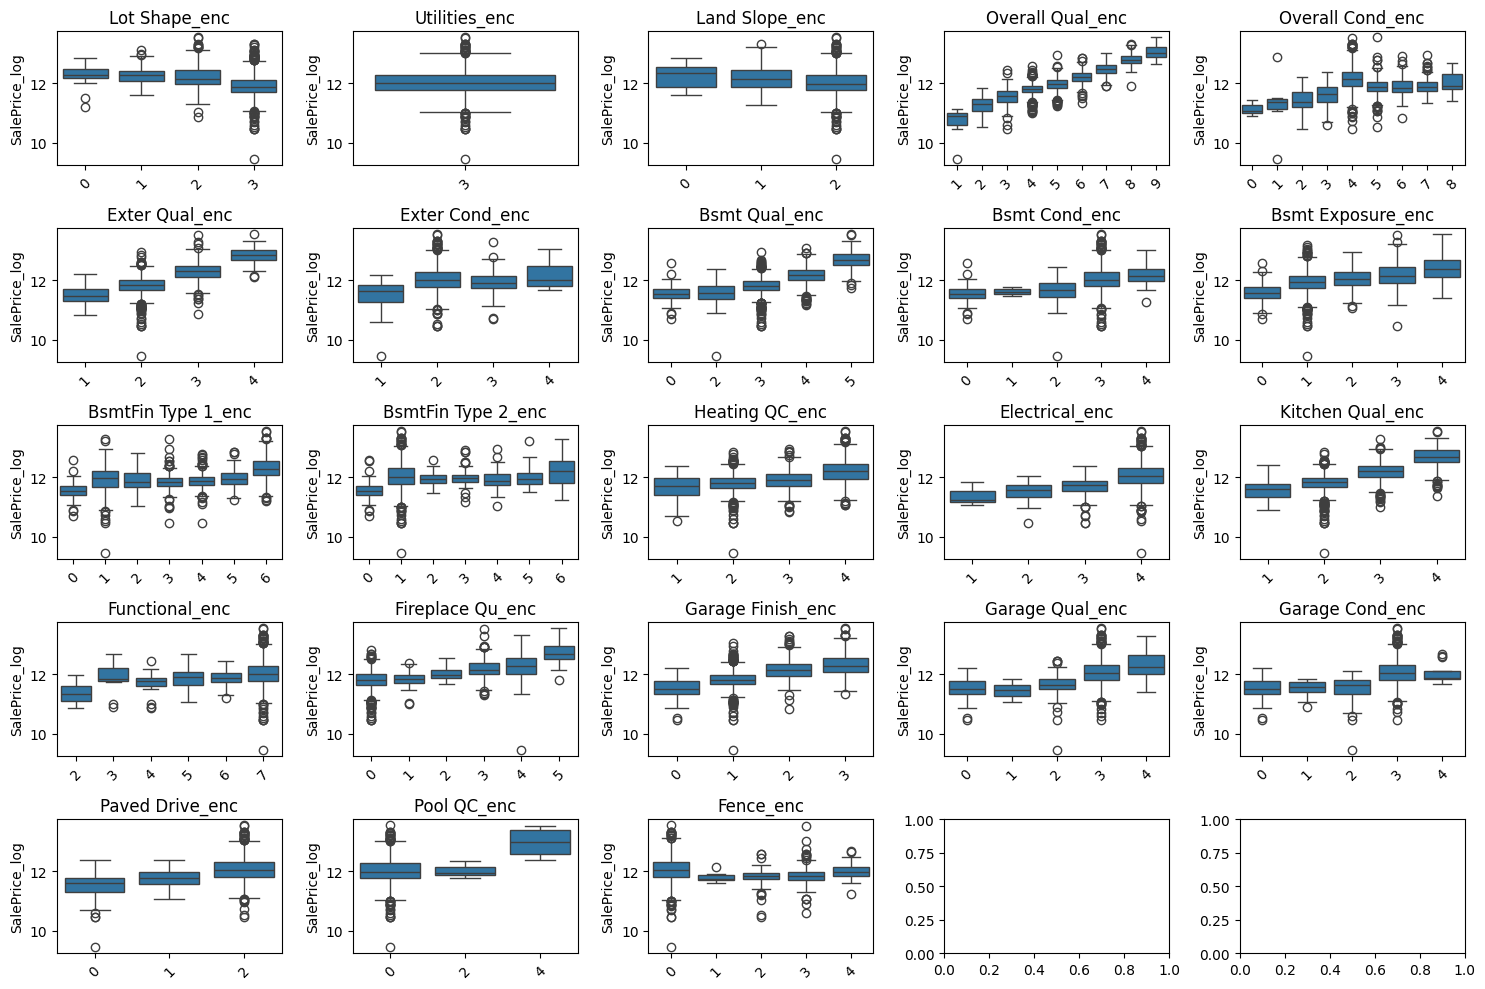

In [47]:
n_cols = 5
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))

for i, col in enumerate(ordinal_features):
    r, c = np.divmod(i, n_cols)
    sns.boxplot(x=col, y='SalePrice_log', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    for label in axs[r, c].get_xticklabels():
        label.set_rotation(45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

__Correlations with target variable__

In [ ]:
# compute correlation of ordinal features with SalePrice
ordinal_corr = df[ordinal_features].corrwith(df['SalePrice']).abs().sort_values(ascending=False)
ordinal_corr_wlog = df[ordinal_features].corrwith(df['SalePrice_log']).abs().sort_values(ascending=False)

print("Correlation of Ordinal Features SalePrice:")
pd.concat([ordinal_corr, ordinal_corr_wlog], axis=1)

Correlation of Ordinal Features SalePrice:


,0,1
Overall Qual_enc,0.80,0.83
Exter Qual_enc,0.70,0.68
Kitchen Qual_enc,0.67,0.66
Bsmt Qual_enc,0.61,0.63
Garage Finish_enc,0.55,0.60
Fireplace Qu_enc,0.55,0.56
Heating QC_enc,0.44,0.48
Bsmt Exposure_enc,0.42,0.40
BsmtFin Type 1_enc,0.34,0.37
Lot Shape_enc,0.30,0.33


__Observations__:
- The features with highest predictin power are. These could maybe even benefit more by being model as polynomial.
    - __'Overall Cond'__
    - __'Exter Qual'__
    - __'Kitchen Qual'__
     
- Many features show a low correlation with 'Sale Price'. These could be combined with others to improve predicting power. Possible groupings are: 
    - __'Lot_Configuration'__: 'Lot Shape', 'Land Slope', 'Fence', 'Paved Drive', 'Extern Cond'
    - __'Bsmt'__
    - __'Utilities_Type'__: 'Utilities', 'Electrical',  'Heating QC'
    - __'Basement'__: 'BsmtFin Type 2'

- For a few features there's a big effect, depending on the labels and specially for predicting high values of 'Sale Price', e.g. 'Bsmt Qual', 'Pool Qc'

## Numerical discrete features

In [37]:
print('Number of numerical discrete features:', len(discrete_features))

Number of numerical discrete features: 14


### Missing Values:

In [38]:
print(f'Total missing values: {df[discrete_features].isna().sum().sum()}')

Total missing values: 134


In [39]:
df_discrete_missing = df[discrete_features].isna().sum().to_frame(name='total')
df_discrete_missing = df_discrete_missing[df_discrete_missing['total']!=0].sort_values('total', ascending=False)
df_discrete_missing['percentage'] = df_discrete_missing['total']/len(df)*100
df_discrete_missing

,total,percentage
Garage Yr Blt,131,5.51
Bsmt Full Bath,1,0.04
Bsmt Half Bath,1,0.04
Garage Cars,1,0.04


__Observation__:
- 'Garage Yr Blt' is the feature with more missing values, these correspond to entries where there is no garage. It's not obvious which value to assign in these cases, the feature definition doesn't make sense for these cases.
- For 'Bsmt Full Bath', 'Bsmt Half Bath' and 'Garage Cars' the number of missing values is very small

__Solution__: 
- check correlation between 'Year Blt' and 'Garage Yr Blt', and if correlation is high we decide to drop the 'Garage Yr Blt' feature altogether
- For 'Bsmt Full Bath', 'Bsmt Half Bath' and 'Garage Cars', fill missing values with the mode.


In [40]:
df[df['Garage Yr Blt'].isna()]['Garage Type'].value_counts()

Garage Type
NA        129
Detchd      2
Name: count, dtype: int64

In [41]:
print(f"Correlation of 'Garage Yr Blt' with 'SalePrice': {df['Garage Yr Blt'].corr(df['Year Built'])}")

Correlation of 'Garage Yr Blt' with 'SalePrice': 0.8363262947400202


As explained before, since the correlation is very high, we decide to drop the feature 'Garage Yr Blt'

In [42]:
df.drop('Garage Yr Blt', axis=1, inplace=True)
discrete_features = df.dtypes[df.dtypes == 'Int64'].index

In [43]:
# Replace missing values with the mode
features = ['Bsmt Full Bath', 'Bsmt Half Bath', 'Garage Cars']

for feature in features:
    mode_value = df[feature].mode()[0]
    df[feature].fillna(mode_value, inplace=True)

In [44]:
print(f"Missing values in discrete columns after cleaning: {df[discrete_features].isna().sum().sum()}")

Missing values in discrete columns after cleaning: 0


### Feature distribution:

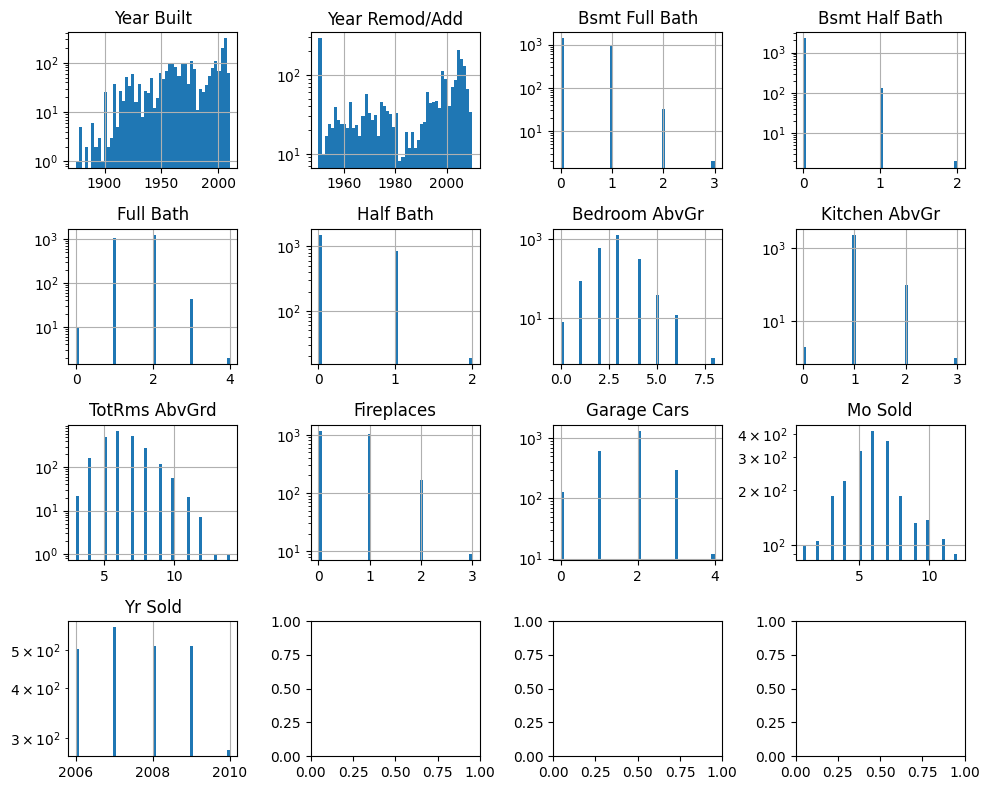

In [45]:
n_cols = 4
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 8))

for i, col in enumerate(discrete_features):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c], log=True)
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

### Outlier removal

__Discrete Features: Values populated with minimum of entries__

In [54]:
print(f'{"Feature":<20}|{"MinValue":<20}|{"MinCount":<20}')
print("-"*50)
for feature in discrete_features:
    
    # Get the number of entries per category
    category_counts = df[feature].value_counts()
    min_count_category = category_counts.idxmin()

    # Display the counts
    print(f'{feature:<20}|{min_count_category:<20}|{min(category_counts):<20}')

Feature             |MinValue            |MinCount            
--------------------------------------------------
Year Built          |1982                |3                   
Year Remod/Add      |1982                |8                   
Bsmt Full Bath      |2                   |31                  
Bsmt Half Bath      |1                   |136                 
Full Bath           |0                   |10                  
Half Bath           |2                   |17                  
Bedroom AbvGr       |0                   |8                   
Kitchen AbvGr       |2                   |90                  
TotRms AbvGrd       |12                  |7                   
Fireplaces          |3                   |9                   
Garage Cars         |4                   |10                  
Mo Sold             |12                  |89                  
Yr Sold             |2010                |275                 


__Observation__:
- Again, for about half of the features there's at least one value populated with just 1 or 2 entries

__Solution__:
- We decide to remove the entries for which there's <=2 counts of a given category;
- We check how many entries we dropped

In [55]:
threshold = 2

for feature in discrete_features:

    category_counts = df[feature].value_counts()
    # Identify categories with counts <= threshold
    low_count_categories = category_counts[category_counts <= threshold].index
    # Filter out entries with low count categories
    df = df[~df[feature].isin(low_count_categories)]


In [56]:
print(f'Percentage of dropped entries: {(2430-df.shape[0])/2430*100:.2f}%')

Percentage of dropped entries: 3.42%


### Relationship with target variable

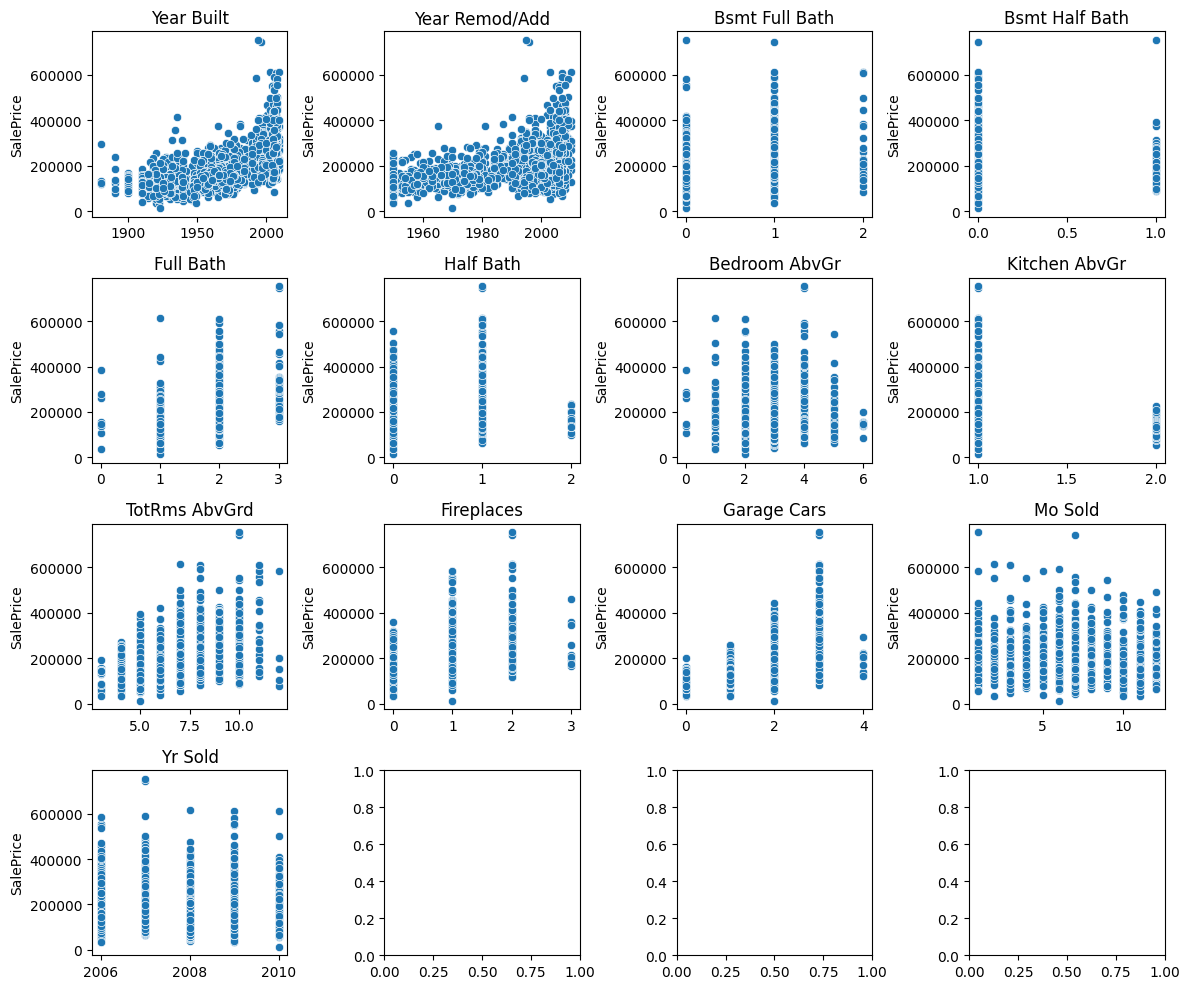

In [57]:
n_cols = 4
n_rows = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,10))

for i, col in enumerate(discrete_features):
    r, c = np.divmod(i, n_cols)
    sns.scatterplot(x=col, y='SalePrice', data=df, ax=axs[r, c])
    #axs[r, c].set_yscale('log')
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
#    for label in axs[r, c].get_xticklabels():
#        label.set_rotation(45)  # Rotate x-axis labels

plt.tight_layout()
plt.show()

__Correlation with target variable__

In [50]:
# compute correlation of discrete features with SalePrice
discrete_corr = df[discrete_features].corrwith(df['SalePrice']).abs().sort_values(ascending=False)
discrete_corr_wlog = df[discrete_features].corrwith(df['SalePrice_log']).abs().sort_values(ascending=False)

print("Correlation of Ordinal Features SalePrice:")
pd.concat([discrete_corr, discrete_corr_wlog], axis=1)


Correlation of Ordinal Features SalePrice:


,0,1
Garage Cars,0.65,0.68
Year Built,0.56,0.62
Full Bath,0.54,0.58
Garage Yr Blt,0.53,0.58
Year Remod/Add,0.52,0.58
TotRms AbvGrd,0.49,0.49
Fireplaces,0.49,0.51
Half Bath,0.28,0.31
Bsmt Full Bath,0.27,0.27
Bedroom AbvGr,0.13,0.17


__Observations__:
- 'Year Built' and 'Year Remod/Add' present significant correlation, but not really linear. From around 1990 there seems to be an increased slope in house prices variation with respect to previous decaded
    - Create binary features indicating propetries that were built or remodeled after 1990
    - Create interaction term between 'Year Built' and 'Year Remod/Add' and check correlation 

- Most variables indicating number of divisions have a relatively weak correlation ('Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath')
    - All these could profit from being lienearly combined in a single feature

- 'Yr Sold' and 'Mo Sold' have the weakest correlation 
    - Can normally be dropped without loosing significant information

## Feature engineering

In [130]:
from sklearn.linear_model import LinearRegression

df_discrete_feateng = pd.DataFrame()
df_discrete_feateng['SalePrice'] = df['SalePrice']


In [131]:
df_discrete_feateng['built_recently'] = df['Year Built'] > 1990
df_discrete_feateng['remod_recently'] = df['Year Remod/Add'] > 1990

print(df_discrete_feateng['built_recently'].corr(df['SalePrice']))
print(df_discrete_feateng['remod_recently'].corr(df['SalePrice']))


0.5833643672015963
0.4751116647152688


In [132]:
df_discrete_feateng['built_remod_inter'] = df['Year Built']*df['Year Remod/Add']
print((df_discrete_feateng['built_remod_inter']).corr(df['SalePrice']))

0.6086958742061285


In [133]:
division_features = ['Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath']
X = df[division_features]
y = df['SalePrice']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

df_discrete_feateng['total_divisions_linear'] = X.dot(model.coef_)

corr_linreg = df_discrete_feateng['total_divisions_linear'] .corr(df['SalePrice'])
corr_sum = df[division_features].sum(axis=1).corr(df['SalePrice'])

print(f'Correlation using linear regression : {corr_linreg:.2f}')
print(f'Correlation using simple sum        : {corr_sum:.2f}')


Correlation using linear regression : 0.75
Correlation using simple sum        : 0.51


The current fit uses information from test data, which represents a leak of the data

## Numerical continuous variable

In [59]:
print('Number of numerical continuous features:', len(continuous_features))

Number of numerical continuous features: 19


### Missing Values:

In [60]:
print(f"Missing values in continuous columns: {df[continuous_features].isna().sum().sum()}")

Missing values in continuous columns: 423


In [61]:
df_continuous_missing = df[continuous_features].isna().sum().to_frame(name='total')
df_continuous_missing = df_continuous_missing[df_continuous_missing['total']!=0].sort_values('total', ascending=False)
df_continuous_missing['percentage'] = df_continuous_missing['total']/len(df)*100
df_continuous_missing

,total,percentage
Lot Frontage,402,17.13
Mas Vnr Area,20,0.85
Garage Area,1,0.04


__Observation__:
- Feature 'Lot Frontage' has a significant ammount of missing values, these could be from properties with no street connection, but this should be verified
- 'Mas Vnr Area' (Masonry veneer area in square feet) with missing values could also be coming from properties with no Masonry veneer surface

__Solution__:
- Observe relation between 'Lot Frontage' and 'Lot Config' for properties with no lot frontage.
- Check if missing values in 'Mas Vnr Area', also have 'Mas Vnr Type' equal to 'NA'
- If previous 

__Missing values in 'Lot Frontage':__

In [62]:
df[df['Lot Frontage'].isna()]['Lot Config'].value_counts()

Lot Config
Inside     224
Corner      82
CulDSac     77
FR2         16
FR3          3
Name: count, dtype: int64

Most missing values in 'Lot Frontage' correspond to lot configurations - 'Inside' and 'CulDSac' - where it seems likely that there's no street connection. We can reasonably assume that these missing values should correpond to 0 feet of street connection of the property.

In [63]:
df.loc[(df['Lot Config'].isin(['Inside', 'CulDSac'])) & (df['Lot Frontage'].isna()), 'Lot Frontage'] = 0

For the remaining missing values in the 'Lot Frontage' column, we will replace them with the median value (more robust to outliers than the mean).

In [64]:
# For the remaining missing values in the 'Lot Frontage' column, we will replace them with the median value.
median_value = df['Lot Frontage'].median()
df['Lot Frontage'].fillna(median_value, inplace=True)

__Missing values in 'Mas Vnr Area':__

In [65]:
df[df['Mas Vnr Area'].isna()]['Mas Vnr Type'].value_counts()

Mas Vnr Type
NA    20
Name: count, dtype: int64

All missing values in 'Mas Vnr Area' correspond to entries where 'Mas Vnr Type' is 'NA', hence it makes sense that these values should actually be zero.

In [66]:
df['Mas Vnr Area'].fillna(0, inplace=True)

__Missing values in 'BsmtFin SF', 'BsmtFin SF', 'Bsmt Unf SF':__

Next we look at the other missing values in some Basement related features. Below we see that the 3 missing values correspond to a single entry, and we decide to drop this entry. Where there's actually no basement (the values 5,4,6 for ordinal variables, after the encoding, correspond to 'NA' - No basement).

In [67]:
df[df['BsmtFin SF 1'].isna() | df['BsmtFin SF 2'].isna() | df['Bsmt Unf SF'].isna() | df['Total Bsmt SF'].isna()][['Bsmt Qual','Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin SF 1','BsmtFin Type 1','BsmtFin SF 2', 'Bsmt Unf SF']]   

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 1,BsmtFin SF 2,Bsmt Unf SF


Hence, we replace the missing Basement features by 0

In [68]:
df['BsmtFin SF 1'].fillna(0, inplace=True)
df['BsmtFin SF 2'].fillna(0, inplace=True)
df['Bsmt Unf SF'].fillna(0, inplace=True)
df['Total Bsmt SF'].fillna(0, inplace=True)

__Missing values in 'Garage Area':__

In [69]:
df[df['Garage Area'].isna() | df['Garage Type'].isna() | df['Garage Finish'].isna() | df['Garage Qual'].isna() | df['Garage Cond'].isna()][['Garage Area','Garage Cars','Garage Type','Garage Finish','Garage Qual','Garage Cond']]   

,Garage Area,Garage Cars,Garage Type,Garage Finish,Garage Qual,Garage Cond
1565,NaN,2,Detchd,NA,NA,NA


Since the entry with missing value in for 'Garage Area' presents rather inconsistent values for remaining garage variables we decide to drop this entry. For meaning of ordinal features values check previously defined encoding.

In [70]:
df.drop(index=1565,inplace=True)

After the previous cleanup, the following reduced number of features with missing values remain:

In [71]:
print(f"Missing values in numerical continuous features after cleaning: {df[continuous_features].isna().sum().sum()}")

Missing values in numerical continuous features after cleaning: 0


### Feature Distribution

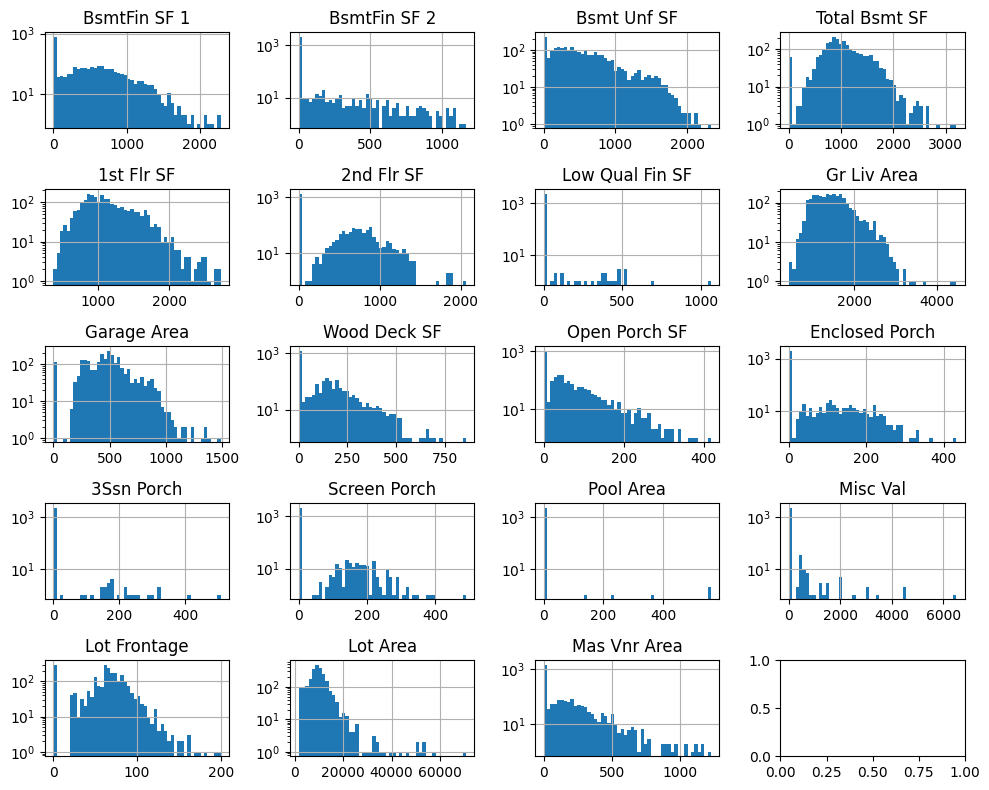

In [83]:
n_cols = 4
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,8))

for i, col in enumerate(continuous_features):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c])
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    axs[r, c].set_yscale('log')
    
plt.tight_layout()
plt.show()

__Observations:__

- Except for 'Total Bsmt SF', '1st Flr SF', 'Gr Liv Area', 'Garage Area', 'Lot Frontage' and 'Lot Area', all other features have most values equal to 0. 

- 'Gr Liv Area' is slightly skewed and could benefit from being replaced by its logarithm.

### Outlier removal

__Continuous Features: Values populated with minimum of entries__

__Observation__:
- By observing the histogram distributions above, we decide to remove data points which lie far away from the main lobe of datapoints (e.g. '1st Flr SF'>3000). 
- However, for features whose values are mostly located zero, except for a few entries, such as 'Pool Area', we will not remove the isolated data points.

__Solution:__
- Remove the following:
    - '1st Flr SF' > 30000
    - 'BsmtFin SF 2' > 1250
    - 'Wood Deck SF' > 1000
    - 'Open Porch SF' > 500
    - 'Enclosed Porch' > 500
    - 'Misc Val' > 10000
    - 'Lot Frontage' > 250
    - 'Lot Area' > 100000
    - 'Mas Vnr Area' > 1500

In [73]:
df.shape

(2346, 79)

In [77]:
df = df[
    (df['1st Flr SF'] <= 3000) &
    (df['BsmtFin SF 2'] <= 1250) &
    (df['Wood Deck SF'] <= 1000) &
    (df['Open Porch SF'] <= 500) &
    (df['Enclosed Porch'] <= 500) &
    (df['Misc Val'] <= 10000) &
    (df['Lot Frontage'] <= 250) &
    (df['Lot Area'] <= 100000) &
    (df['Mas Vnr Area'] <= 1500)
]


In [85]:
print(f'Percentage of dropped entries: {(2430-df.shape[0])/2430*100:.2f}%')

Percentage of dropped entries: 4.20%


We next plot again the feature distributions, but this time with linear scale on y-axis (counts) 

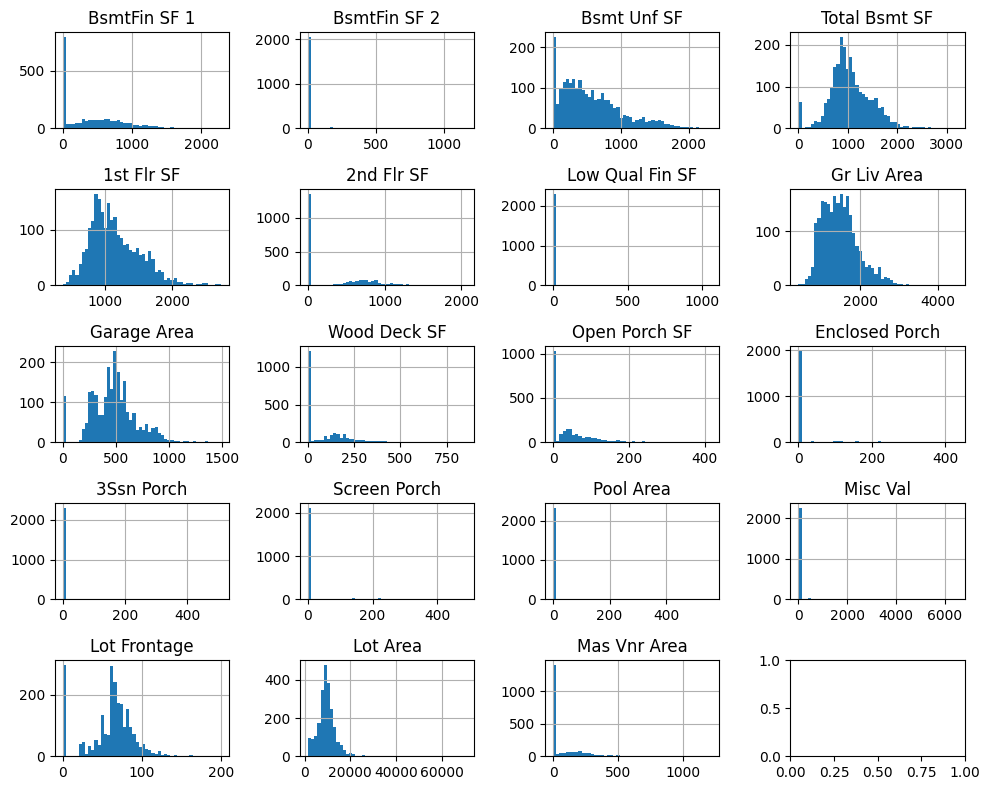

In [82]:
n_cols = 4
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10,8))

for i, col in enumerate(continuous_features):
    r, c = np.divmod(i, n_cols)
    df[col].hist(bins=50, ax=axs[r, c])
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')
    
plt.tight_layout()
plt.show()

__Obsevation__:
- The following features have most or a high percentage of entries equal to zero: 'BsmtFin SF 2', 'BsmtFin SF 2', '2nd Flr SF', 'Low Qual Fin Sf', 'Wood Deck SF', 'Open Porch SF', 'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val', 'Mas Vnr Area'
- Since having them as continuous features, doesn't add much information, they could be replaced by binary variables, which indicate the presence or not of the given feature.

### Relationship with target variable

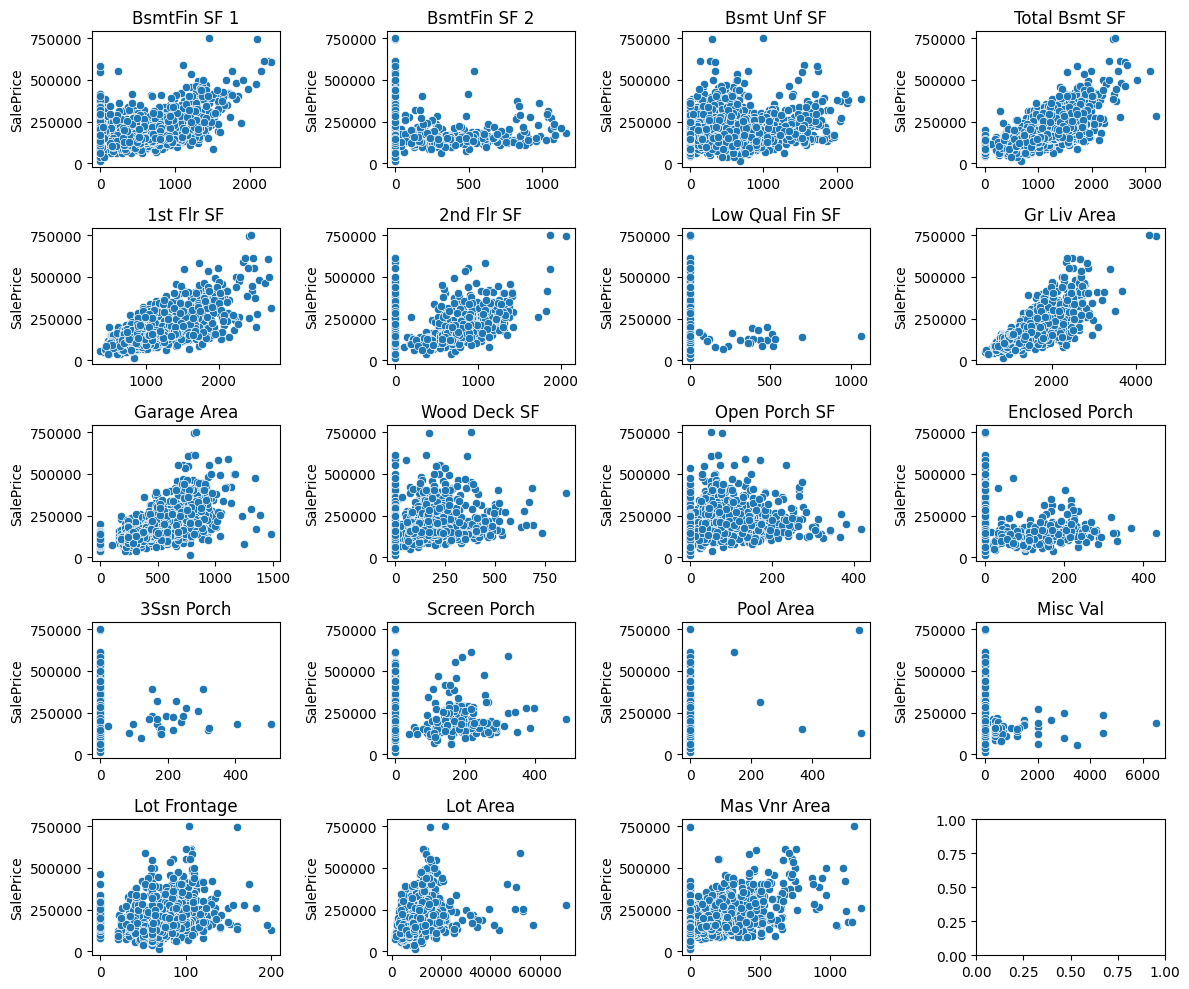

In [86]:
n_cols = 4
n_rows = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,10))

for i, col in enumerate(continuous_features):
    r, c = np.divmod(i, n_cols)
    sns.scatterplot(x=col, y='SalePrice', data=df, ax=axs[r, c])
    axs[r, c].set_title(col, y=1.0)
    axs[r, c].set_xlabel('')

plt.tight_layout()
plt.show()

__Correlation with target variable__

In [87]:
correlations = df[continuous_features].corrwith(df['SalePrice']).abs().sort_values(ascending=False)
print("Correlation of numerical continuous features with SalePrice:")
print(correlations)

Correlation of numerical continuous features with SalePrice:
Gr Liv Area       0.73
Total Bsmt SF     0.67
1st Flr SF        0.65
Garage Area       0.64
Mas Vnr Area      0.52
BsmtFin SF 1      0.46
Lot Area          0.35
Open Porch SF     0.33
Wood Deck SF      0.32
2nd Flr SF        0.25
Lot Frontage      0.22
Bsmt Unf SF       0.19
Enclosed Porch    0.15
Pool Area         0.11
Screen Porch      0.10
Low Qual Fin SF   0.06
3Ssn Porch        0.04
Misc Val          0.04
BsmtFin SF 2      0.02
dtype: float64


Exploration of different eng. features 

In [150]:
df_exp = pd.DataFrame()
df_exp['SalePrice'] = df['SalePrice']

for feature in continuous_features:
    df_exp[feature+'_log'] = np.log(df[feature])

In [151]:
correlations = df_exp[continuous_features].corrwith(df['SalePrice']).abs().sort_values(ascending=False)
print("Correlation of numerical continuous features with SalePrice:")
print(correlations)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 correlations = df_exp[continuous_features].corrwith(df['SalePrice']).abs().sort_values(a     │
│   2 print("Correlation of numerical continuous features with SalePrice:")                        │
│   3 print(correlations)                                                                          │
│   4                                                                                              │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/frame.py:3899 in __getitem__                                                                 │
│                                                                                                  │
│    3896 │   │   else:                                                                            │
│    3897 │   │   │   if is_iterator(key):                                                         │
│    3898 │   │   │   │   key = list(key)                                                          │
│ ❱  3899 │   │   │   indexer = self.columns._get_indexer_strict(key, "columns")[1]                │
│    3900 │   │                                                                                    │
│    3901 │   │   # take() does not accept boolean indexers                                        │
│    3902 │   │   if getattr(indexer, "dtype", None) == bool:                                      │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/indexes/base.py:6114 in _get_indexer_strict                                                  │
│                                                                                                  │
│   6111 │   │   else:                                                                             │
│   6112 │   │   │   keyarr, indexer, new_indexer = self._reindex_non_unique(keyarr)               │
│   6113 │   │                                                                                     │
│ ❱ 6114 │   │   self._raise_if_missing(keyarr, indexer, axis_name)                                │
│   6115 │   │                                                                                     │
│   6116 │   │   keyarr = self.take(indexer)                                                       │
│   6117 │   │   if isinstance(key, Index):                                                        │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/indexes/base.py:6175 in _raise_if_missing                                                    │
│                                                                                                  │
│   6172 │   │   │   if nmissing == len(indexer):                                                  │
│   6173 │   │   │   │   if use_interval_msg:                                                      │
│   6174 │   │   │   │   │   key = list(key)                                                       │
│ ❱ 6175 │   │   │   │   raise KeyError(f"None of [{key}] are in the [{axis_name}]")               │
│   6176 │   │   │                                                                                 │
│   6177 │   │   │   not_found = list(ensure_index(key)[missing_mask.nonzero()[0]].unique())       │
│   6178 │   │   │   raise KeyError(f"{not_found} not in inde

In [84]:
division_features = ['Wood Deck SF','Open Porch SF', '3Ssn Porch', 'Screen Porch']
X = df[division_features]
y = df['SalePrice']

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

df_discrete_feateng['total_divisions_linear'] = X.dot(model.coef_)

corr_linreg = df_discrete_feateng['total_divisions_linear'] .corr(df['SalePrice'])
corr_sum = df[division_features].sum(axis=1).corr(df['SalePrice'])

print(f'Correlation using linear regression : {corr_linreg:.2f}')
print(f'Correlation using simple sum        : {corr_sum:.2f}')

Correlation using linear regression : 0.45
Correlation using simple sum        : 0.43


In [ ]:
(df['Gr Liv Area']+df['Lot Area']).corr(df['SalePrice'])

__Observation__:
- Feature 'Gr Liv Area' presents the

__Correlation among feature variables__

## Inconsistencies

We start by looking at the possible values in the Categorical features

Next we'll analyse possible incosistencies among the following related variables:

- Basement variables
- Garage Year Built
- Finished vs living areas
- 'Year Built' vs 'Year Remod/Add'

### Basement variables

Next we check for possible inconsistencies in Basement related features with missing values

In [55]:
basement_features = ['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']

We start by looking at entries where at least one feature indicates 'NA', but where this is inconsistent witht he other features.

In [56]:
q1 = '(`Bsmt Qual` == "NA") | (`Bsmt Exposure` == "NA") | (`BsmtFin Type 1` == "NA") | (`BsmtFin Type 2` == "NA")'
q2 = '~((`Bsmt Qual` == "NA") & (`Bsmt Exposure` == "NA") & (`BsmtFin Type 1` == "NA") & (`BsmtFin Type 2` == "NA") & (`BsmtFin SF 1` == 0.00) & (`BsmtFin SF 2` == 0.00) & (`Bsmt Unf SF` == 0.00) & (`Total Bsmt SF` == 0.00) & (`Bsmt Full Bath` == 0) & (`Bsmt Half Bath` == 0))'
df.query(q1).query(q2)[basement_features]

,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Bsmt Full Bath,Bsmt Half Bath
602,Gd,TA,No,GLQ,1124.00,NA,479.00,1603.00,3206.00,1,0
875,Gd,TA,NA,Unf,0.00,Unf,0.00,1595.00,1595.00,0,0
1681,Gd,TA,NA,Unf,0.00,Unf,0.00,725.00,725.00,0,0
1726,Gd,TA,NA,Unf,0.00,Unf,0.00,936.00,936.00,0,0


__Observation__:
- The previous entries show some kind of inconsistency, among the variables describing the basement facilities

__Solution__:
- Since these are only a few entries, we'll fix the entries using common sense
- We'll populate the column `'Bsmt Exposure'` of entries 875, 1681 and 1726, where  indicates there is no basement but we there's a basement in Unfinished conditions, with `'Bsmt Exposure'=='No'` that indicates no exposure to outside

In [57]:
df.loc[104, ['BsmtFin SF 1','BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']] = 0
df.loc[602, ['BsmtFin Type 2']] = 'Unf'
df.loc[[875,1681, 1726], ['Bsmt Exposure']] = 'No'

Next we check for potential inconsistencies among the various surface features.

In [58]:
inconsistent_basement_surface = (df['BsmtFin SF 1'] + df['BsmtFin SF 2'] + df['Bsmt Unf SF']) != df['Total Bsmt SF']
inconsistent_basement_surface.sum()

0

__Observation__:
- The Basement surface features are consistent among for all entries

### Garage Variables

In [59]:
garage_features = ['Garage Type', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']

Again, we start by looking at entries where at least one feature indicates 'NA', but where this is inconsistent witht he other features.

In [60]:
q1 = '(`Garage Type` == "NA") | (`Garage Finish` == "NA") | (`Garage Cars` == 0) | (`Garage Area` == 0) | (`Garage Qual` == "NA") & (`Garage Cond` == "NA")'
q2 = '~((`Garage Type` == "NA") & (`Garage Finish` == "NA") & (`Garage Cars` == 0) & (`Garage Area` == 0) & (`Garage Qual` == "NA") & (`Garage Cond` == "NA"))'
df.query(q1).query(q2)[garage_features]

,Garage Type,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond
1114,Detchd,NA,1,360.00,NA,NA


__Observation__:
- There are two entries with inconsistent values

__Solution__:
- We decide to drop these since they are just two

In [61]:
df.drop([1114, 1565], inplace=True)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 df.drop([1114, 1565], inplace=True)                                                          │
│   2                                                                                              │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/frame.py:5344 in drop                                                                        │
│                                                                                                  │
│    5341 │   │   falcon  speed   320.0   250.0                                                    │
│    5342 │   │   │   │   weight  1.0     0.8                                                      │
│    5343 │   │   """                                                                              │
│ ❱  5344 │   │   return super().drop(                                                             │
│    5345 │   │   │   labels=labels,                                                               │
│    5346 │   │   │   axis=axis,                                                                   │
│    5347 │   │   │   index=index,                                                                 │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/generic.py:4711 in drop                                                                      │
│                                                                                                  │
│    4708 │   │                                                                                    │
│    4709 │   │   for axis, labels in axes.items():                                                │
│    4710 │   │   │   if labels is not None:                                                       │
│ ❱  4711 │   │   │   │   obj = obj._drop_axis(labels, axis, level=level, errors=errors)           │
│    4712 │   │                                                                                    │
│    4713 │   │   if inplace:                                                                      │
│    4714 │   │   │   self._update_inplace(obj)                                                    │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/generic.py:4753 in _drop_axis                                                                │
│                                                                                                  │
│    4750 │   │   │   │   │   raise AssertionError("axis must be a MultiIndex")                    │
│    4751 │   │   │   │   new_axis = axis.drop(labels, level=level, errors=errors)                 │
│    4752 │   │   │   else:                                                                        │
│ ❱  4753 │   │   │   │   new_axis = axis.drop(labels, errors=errors)                              │
│    4754 │   │   │   indexer = axis.get_indexer(new_axis)                                         │
│    4755 │   │                                                                                    │
│    4756 │   │   # Case for non-unique axis                                                       │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school

### Year Built vs Year Remod/Add vs Year Sold 

We verify that the following conditions are verified:
-  'Yr Sold' >= 'Year Remod/Add'
- 'Year Remod/Add' >= 'Year Built' 

In [76]:
df[df['Year Remod/Add'] < df['Year Built']]

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice


In [176]:
q = '(`Year Built` > `Yr Sold`)'
df.query(q)[['Year Built', 'Year Remod/Add', 'Yr Sold']]

,Year Built,Year Remod/Add,Yr Sold
71,2008,2009,2007


__Observation__:  
- No inconsistencies observed between 'Year Built' and 'Year Remod/Add'
- For entrie 71 the 'Yr Sold' should be at least 2009

__Solution__:  
- Manually change this value

In [177]:
# Change value of Yr SOld for entry 71 to 2009
df.loc[71,'Yr Sold'] = 2009

### Misc Feature and Misc Val

When there is no 'Misc Feature' the corresponding 'Misc Val' should be 0 

In [178]:
q = '(`Misc Feature` ==  "NA") & (`Misc Val` != 0)'
df.query(q)[['Misc Feature', 'Misc Val']]

,Misc Feature,Misc Val


__Observations__:  
- No inconsistencies observed

## Outliers

### Statistics of numerical features

__Min and Max values of Numerical continuous features__

In [152]:
df[continuous_features].describe().T

,count,mean,std,min,25%,50%,75%,max
BsmtFin SF 1,2429.00,443.72,457.54,0.00,0.00,375.00,737.00,5644.00
BsmtFin SF 2,2429.00,51.07,172.14,0.00,0.00,0.00,0.00,1526.00
Bsmt Unf SF,2429.00,556.35,439.77,0.00,216.00,462.00,799.00,2336.00
Total Bsmt SF,2429.00,1051.15,445.18,0.00,793.00,990.00,1299.00,6110.00
1st Flr SF,2429.00,1159.93,393.15,334.00,880.00,1086.00,1388.00,5095.00
2nd Flr SF,2429.00,326.44,419.42,0.00,0.00,0.00,698.00,2065.00
Low Qual Fin SF,2429.00,4.59,47.23,0.00,0.00,0.00,0.00,1064.00
Gr Liv Area,2429.00,1490.97,496.23,334.00,1120.00,1440.00,1740.00,5642.00
Garage Area,2429.00,471.98,215.75,0.00,324.00,478.00,576.00,1488.00
Wood Deck SF,2429.00,93.88,128.12,0.00,0.00,0.00,168.00,1424.00


__Min and Max values of Numerical discrete features__

In [89]:
df[discrete_features].describe().loc[['min', 'max']].T

,min,max
MS SubClass,20.00,190.00
Overall Qual,1.00,10.00
Overall Cond,1.00,9.00
Year Built,1875.00,2010.00
Year Remod/Add,1950.00,2010.00
Bsmt Full Bath,0.00,3.00
Bsmt Half Bath,0.00,2.00
Full Bath,0.00,4.00
Half Bath,0.00,2.00
Bedroom AbvGr,0.00,8.00


# Feature Engineering

# Dataset splitting

In [55]:
from sklearn.model_selection import train_test_split

# split the df dataset into training and validation sets
# Define the target variable and features
X = df.drop(columns=['SalePrice'])
y = df['SalePrice']

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 1458
Validation set size: 972


# Model evaluation

# Model fitting

## Baseline model

The baseline model prediction is simply the mean of the 'Sale Price' for all entries, and does not depend on any of the features

In [61]:
baseline_model = LinearRegression()

# Reshape target mean to fit the LinearRegression format (as a single feature)
pred_baseline_val = np.full_like(y_val, fill_value=np.mean(y_train), dtype=float)


## Simple Model

__Observation__:
- The two variables with the highest correlation values with 'Sale Price' are: 'Gr Liv Area' and 'Overall Qual'  

__Solution__:
- Use these two features in the simple model as may provide higehet prediction power

In [62]:
from sklearn.linear_model import LinearRegression

# Create a linear regression object
model_simple = LinearRegression()

features_simple = ['Overall Qual', 'Gr Liv Area']


# Fit the model
model_simple.fit(X_train[features_simple], y_train)



╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:10                                                                                   │
│                                                                                                  │
│    7                                                                                             │
│    8                                                                                             │
│    9 # Fit the model                                                                             │
│ ❱ 10 model_simple.fit(X_train[features_simple], y_train)                                         │
│   11                                                                                             │
│   12 df_feature['total_divisions'] = X.dot(model.coef_)                                          │
│   13                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'X_train' is not defined

In [173]:
evaluate_model(model_simple, X_val[features_simple], y_val)

Mean Absolute Error (MAE): 27.691 thousand dollars
R-squared (R2): 0.73


## Complex Model

In [183]:
from sklearn.linear_model import LinearRegression

# Create a linear regression object
model_simple = LinearRegression()

features_complex = continuous_features.drop(['SalePrice'])

# Fit the model
model_simple.fit(X_train[features_complex], y_train)

evaluate_model(model_simple, X_val[features_simple], y_val)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:11                                                                                   │
│                                                                                                  │
│    8 # Fit the model                                                                             │
│    9 model_simple.fit(X_train[features_complex], y_train)                                        │
│   10                                                                                             │
│ ❱ 11 evaluate_model(model_simple, X_val[features_simple], y_val)                                 │
│   12                                                                                             │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/frame.py:3899 in __getitem__                                                                 │
│                                                                                                  │
│    3896 │   │   else:                                                                            │
│    3897 │   │   │   if is_iterator(key):                                                         │
│    3898 │   │   │   │   key = list(key)                                                          │
│ ❱  3899 │   │   │   indexer = self.columns._get_indexer_strict(key, "columns")[1]                │
│    3900 │   │                                                                                    │
│    3901 │   │   # take() does not accept boolean indexers                                        │
│    3902 │   │   if getattr(indexer, "dtype", None) == bool:                                      │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/indexes/base.py:6114 in _get_indexer_strict                                                  │
│                                                                                                  │
│   6111 │   │   else:                                                                             │
│   6112 │   │   │   keyarr, indexer, new_indexer = self._reindex_non_unique(keyarr)               │
│   6113 │   │                                                                                     │
│ ❱ 6114 │   │   self._raise_if_missing(keyarr, indexer, axis_name)                                │
│   6115 │   │                                                                                     │
│   6116 │   │   keyarr = self.take(indexer)                                                       │
│   6117 │   │   if isinstance(key, Index):                                                        │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/pandas/c │
│ ore/indexes/base.py:6178 in _raise_if_missing                                                    │
│                                                                                                  │
│   6175 │   │   │   │   raise KeyError(f"None of [{key}] are in the [{axis_name}]")               │
│   6176 │   │   │                                                                                 │
│   6177 │   │   │   not_found = list(ensure_index(key)[missing_mask.nonzero()[0]].unique())       │
│ ❱ 6178 │   │   │   raise KeyError(f"{not_found} not in index")                                   │
│   6179 │                                                                                         │
│   6180 │   @overload                                       

In [178]:
features_complex

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Cars', 'Garage

In [2]:
from sklearn.linear_model import LinearRegression

# Create a linear regression object
model_simple = LinearRegression()

features_complex = continuous_features.drop(['SalePrice'])

# Fit the model
model_simple.fit(X_train[features_complex], y_train)

model_metric(model_simple, X_val[features_simple], y_val)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│    3 # Create a linear regression object                                                         │
│    4 model_simple = LinearRegression()                                                           │
│    5                                                                                             │
│ ❱  6 features_complex = continuous_features.drop(['SalePrice'])                                  │
│    7                                                                                             │
│    8 # Fit the model                                                                             │
│    9 model_simple.fit(X_train[features_complex], y_train)                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'continuous_features' is not defined

In [178]:
features_complex

Index(['MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street',
       'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual',
       'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF',
       'Gr Liv Area', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual',
       'TotRms AbvGrd', 'Functional', 'Fireplaces', 'Fireplace Qu',
       'Garage Type', 'Garage Finish', 'Garage Cars', 'Garage

# Evaluation metric

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score#, root_mean_squared_error

def evaluate_metric(y_pred, y_test):
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    #rms = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Print MAE in dollars
    print(f"Mean Absolute Error (MAE): {mae/1000:.3f} thousand dollars")
    #print(f"Root Mean Squared Error (RMSE): {rms/1000:.3f} dollars")
    print(f"R-squared (R2): {r2:.2f}")

In [62]:
print(f'Baseline Model')
evaluate_metric(pred_baseline_val, y_val)

Baseline Model
Mean Absolute Error (MAE): 55.733 thousand dollars
R-squared (R2): -0.00
